# One-file code for the simulations

To install all required packages and dependencies, run the following cell (only needs to be run once):

In [12]:
using Pkg
Pkg.add("Random")
Pkg.add("Distributions")
Pkg.add("DataFrames")
Pkg.add("StatsBase")
Pkg.add("CairoMakie")
Pkg.add("ProgressMeter")
Pkg.add("JLD2")
Pkg.add("Integrals")
Pkg.add("CodecZlib")

   Resolving package versions...
  No Changes to `C:\Users\ov22\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\ov22\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\ov22\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\ov22\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\ov22\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\ov22\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\ov22\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\ov22\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\ov22\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\ov22\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\ov22\.julia\environments\v1.10\Project.toml`
  No Changes to 

## Model implementation code

In [13]:
using Pkg
using Random, Distributions, DataFrames, StatsBase, CairoMakie, ProgressMeter, JLD2, Integrals



# Core model elements
# Mating model

Mating = function (; Nf, Nm, E, ff, r_sex, beta=0, M2=10, M=4, tp=Int64,wa=1)
    # Pre-allocate arrays
    N_pairs_A = zeros(tp, M2, M2)
    N_pairs_Af = zeros(tp, M2, M2)
    N_exp_f = zeros(tp, M2)
    N_exp_m = zeros(tp, M2)
    
    Nm_sum = sum(Nm.*wa)
    if Nm_sum == 0
        return N_exp_f, N_exp_m  # Early return if no males
    end
    pAm = Nm.*wa ./ Nm_sum
    p_beta = Nm_sum / (beta + Nm_sum)

    # Vectorized mating pair sampling
    @inbounds for i in 1:M2
        if Nf[i] > 0
            n_pairs = round(tp, Nf[i] * p_beta)
            if n_pairs > 0
                N_pairs_A[i, :] .= rand(Multinomial(n_pairs, pAm))
            end
        end
    end

    # Vectorized offspring production
    @inbounds for j in 1:M2, i in 1:M2
        if N_pairs_A[i, j] > 0
            # Sample fertile pairs and offspring in one step
            N_pairs_Af[i, j] = rand(Poisson(N_pairs_A[i, j] * ff[i, j]))
            
            if N_pairs_Af[i, j] > 0
                N_exp = rand(Multinomial(N_pairs_Af[i, j], E[i][j]))
                # Sex allocation - vectorized
                N_sx = rand.(Binomial.(N_exp, 1 .- r_sex[j, i]))
                
                N_exp_f .+= N_sx
                N_exp_m .+= N_exp .- N_sx
            end
        end
    end

    return N_exp_f, N_exp_m
end

# Fitness change: survival/sterility effects in adults
Fitness_change = function (; Nf, Nm, wf, wm, M2=10)
    Nf_new = first.(rand.(Binomial.(Nf, wf), 1))
    Nm_new = first.(rand.(Binomial.(Nm, wm), 1))
    return Nf_new, Nm_new
end
#Density-dependent mortality
Alpha=function(;N, f,phi1=1, phi2=1,tp=Int64)
    if phi2==1
        a = (N*f/2)/(phi1*f/2-1)
    else 
        a= (N*f/2)/(phi1*f/2-1)^(1/phi2)
    end
    return a
end

 Ddm_change=function(; Nf, Nm, Nh, alpha, M2=10, tp=Int64,phi1=1,phi2=1)
    p = phi1 / ((Nh/alpha)^phi2 + 1)
    
    # Pre-allocate and fill directly
    Nf_new = Vector{tp}(undef, M2)
    Nm_new = Vector{tp}(undef, M2)
    
    @inbounds for i in 1:M2
        Nf_new[i] = rand(Binomial(Nf[i], p))
        Nm_new[i] = rand(Binomial(Nm[i], p))
    end
    
    return Nf_new, Nm_new
end

# Model for 1 generational change
# Ntfi/Ntmi for total adult population, Ntf/Ntm for fertile adult population, counted per genotype
Model2 = function (; Nf, Nm, E, wm, wf, alpha=10^6, ff, r_sex=0.5, beta=1, M2=10, M=4,tp=Int64,phi1=1,phi2=1,wa=1)
    Nf, Nm = Mating(; Nf=Nf, Nm=Nm, E=E, ff=ff, r_sex=r_sex, beta=beta, M2=M2, M=M,tp=tp,wa=wa)
    Nh = sum(Nf .+ Nm)
    Nf_1, Nm_1 = Ddm_change(; Nf=Nf, Nm=Nm, Nh=Nh, alpha=alpha, M2=M2,phi1=phi1,phi2=phi2)[1:2]
    Nf_2, Nm_2 = Fitness_change(; Nf=Nf_1, Nm=Nm_1, wf=wf, wm=wm, M2=M2)
    return [Nf_2, Nm_2]#Ntf, Ntm, Ntfi, Ntmi
end

# Population size input
Input_nosp = function (; M=4, Nmean=10^5, pm=0.01,tp=Int64)
    M2 = Int(M * (M + 1) / 2)
    Ntf_init = zeros(tp,M2)
    Ntf_init[1] = tp(round(Nmean / 2))
    Ntm_init = zeros(tp,M2)
    Ntm_init[1] = tp(round(Nmean / 2))
    Ntm_init[M+1] = ceil(tp, Ntm_init[1] * pm)
    Ntm_init[1] = ceil(tp, Ntm_init[1] * (1 - pm))
    return Ntf_init, Ntm_init
end

# Full simulations over time. Tracking only cumulative population size by sex
# Parameters: maxgen=number of generations
# N=total effective population size
# beta=parameter of probability of successfully finding a male mate in small population, e.g., p=(number of males)/(number of males+beta). Not used in non-spatial modelling
# wmf=fitness and reproduction data, generated by Fitness_input1 function
# e=gametes production data,  generated by E_Make_1 function
# alpha=parameter related to density depending mortality. Alpha=0 for equilibrium = N
# phi1, phi2 are parameters from the density-dependency model (Maynard Smith & Blatkin). When phi1=phi2=1 is equal to the Beverton-Holt model
# M=4 or M=5 = number of alleles (M=5 for drive with no sex distorter)
#pm = initial DD drive males release frequency

 Model_nosp_NT=function(; N=10^15, pm=0.01, wmf,e, mD_sex, beta=0, alpha=0,phi1=1,phi2=1, maxgen=10, Model=2, M=4,tp=Int64,b2=0)
    Ntf_init, Ntm_init = Input_nosp(; M=M, Nmean=N, pm=pm,tp=tp)
   
    M2 = Int(M * (M + 1) / 2)
    f=wmf[3][1,1]
    alpha = alpha == 0 ? Alpha(phi1=phi1,phi2=phi2, f=f,N=N) : alpha

    r_sex = 0.5 .* ones(M2, M2)
    if M == 4
        for i in [2, 5, 6, 7]
            r_sex[i, :] .= mD_sex
        end
    end
    if M == 5
        for i in [2, 6, 7, 8, 9]
            r_sex[i, :] .= mD_sex
        end
    end
    if b2>0     
        if M==4 r_sex[7,:] .=0.5 ;end
        if M==5 r_sex[9,:] .=0.5 ;end
    end
    model = Model == 2 ? Model2 : Model1

    NCountF=Array{tp}(undef, maxgen)
    NCountM=Array{tp}(undef, maxgen)

    
    Ntf, Ntm = copy(Ntf_init), copy(Ntm_init)
    NCountF[1]=sum(Ntf_init)
    NCountM[1]=sum(Ntm_init)

    for gen in 1:(maxgen - 1)
        # Reproduction change
       
        if (NCountM[gen]>1) * (NCountF[gen]>1)> 0
            beta = NCountM[gen] / (NCountM[gen] + beta)
            m = model(; Nf=Ntf, Nm=Ntm, E=e, alpha=alpha, ff=wmf[3], wm=wmf[1], wf=wmf[2], r_sex=r_sex,phi1=phi1,phi2=phi2, beta=beta, M2=M2, M=M,tp=tp)
            Ntf = m[1]
            Ntm = m[2]
            
        else
            Ntf, Ntm = zeros(tp, M2), zeros(tp, M2)
        end
        NCountM[gen+1] = sum(Ntm)
        NCountF[gen+1] = sum(Ntf)
    end
    dc_ = [NCountF, NCountM]
    return dc_
end


#Additional functions
Genot=function(;A,M2,M)
    v = Array{Float64}(undef,M2)
    k=0
    for i in 1:M
        v[k+=1] =A[i,i]
        for j in (i+1):M
            v[k+=1]=A[i,j]+A[j,i]
        end
    end
    return v
end

# Gametes produced probability (genotype) 
E_Make_1=function(;c=0.95,j=0.03,a=0.01,b=0.001,show=false,M=4,title="Gametes produces")
    if M==5
        E5=vcat(
            [1 0 0 0 0],
            [(1-c)/2 (1/2+c*(1-j)*(1-a)/2) c*j*(1-b)/2 c*j*b/2 c*(1-j)*a/2],
            [1/2 0 1/2 0 0],
            [1/2 0 0 1/2 0],
            [(1-c)/2 0 c*j*(1-b)/2 c*j*b/2 (1/2+c*(1-j)/2)],
            [0 1 0 0 0],
            [0 1/2 1/2 0 0],
            [0 1/2 0 1/2 0],
            [0 1/2 0 0 1/2],
            [0 0 1 0 0],
            [0 0 1/2 1/2 0],
            [0 0 1/2 0 1/2],
            [0 0 0 1 0],
            [0 0 0 1/2 1/2],
            [0 0 0 0 1]
            )

    end
    if M==4
        E5=vcat(
            [1 0 0 0 ],
            [(1-c)/2 (1/2+c*(1-j)/2) c*j*(1-b)/2 c*j*b/2 ],
            [1/2 0 1/2 0 ],
            [1/2 0 0 1/2 ],
            [0 1 0 0 ],
            [0 1/2 1/2 0 ],
            [0 1/2 0 1/2 ],
            [0 0 1 0 ],
            [0 0 1/2 1/2 ],
            [0 0 0 1 ]
            )

    end    
    return transpose(E5)
end
# Gametes produced probability (sex-specific homing)

# f x m gametes pairs produced by each genotype pair
E_mat=function(;Ef,Em,M2,M)
    E_temp=[[Ef[:,i]*transpose(Em[:,j]) for i in 1:M2] for j in 1:M2]
    e=[[Genot(;A=E_temp[i][j],M=M,M2=M2) for i in 1:M2] for j in 1:M2]
    return e
end

# gametes production final function. Allows for homing in female/males/both
E_Make = function (; M=4, homing=:b, c_m=0.9, j_m=035, a_m=0, b_m=0.001, c_f=0.9, j_f=0.035, a_f=0, b_f=0.001, show=false)
    M2 =Int(M*(M+1)/2)
    if homing == :b
        if show
            println("Homing in both sexes")
        end
        Em = E_Make_1(; c=c_m, j=j_m, a=a_m, b=b_m, show=show, M=M, title="Gametes produced (males)")
        Ef = E_Make_1(; c=c_f, j=j_f, a=a_f, b=b_f, show=show, M=M, title="Gametes produced (females)")
    elseif homing == :m
        if show
            println("Homing in males")
        end
        Em = E_Make_1(; c=c_m, j=j_m, a=a_m, b=b_m, show=show, M=M, title="Gametes produced (males)")
        Ef = E_Make_1(; c=0, j=0, a=0, b=0, show=false, M=M, title="Gametes produced (females)")
    elseif homing == :f
        if show
            println("Homing in females")
        end
        Em = E_Make_1(; c=0, j=0, a=0, b=0, show=false, M=M, title="Gametes produced (males)")
        Ef = E_Make_1(; c=c_f, j=j_f, a=a_f, b=b_f, show=show, M=M, title="Gametes produced (females)")
    end
    e = E_mat(; Ef=Ef, Em=Em, M2=M2, M=M)
    return e
end

Fitness_input1=function(;sigma=0.02,s=1,h=1,hN=0.03,hDR=0.03,show=true,M=4,hm=0,f=12,inter=true,wf_nb=[],non_func=["D","N","O"])
    M2=Int(M*(M+1)/2)
    wm=ones(M2)
    if M==5
        wf0=[1,
        1-h*s,
        1-hN*s,
        1-sigma,
        1-h*s,
        1-s,
        1-s,
        (1-sigma)*(1-hDR*s),
        1-s,
        1-s,
        (1-sigma)*(1-hN*s),
        1-s,
        (1-sigma)^2,
        (1-sigma)*(1-hDR*s),
        1-s
        ]
        wfth=["1",
        "1-hs",
        "1-hN*s",
        "1-sigma",
        "1-h*s",
        "1-s",
        "1-s",
        "(1- sigma)(1-hDRs)",
        "1-s",
        "1-s",
        "(1-sigma)(1-hN*s)",
        "1-s",
        "(1-sigma)^2",
        "(1-sigma)(1-hDR*s)",
        "1-s"
        ]
        namesG=["WW","WD","WN","WR","WO","DD","DN","DR","DO","NN","NR","NO", "RR","RO","OO"]
        
     end
    if M==4
        wf0=[1,
        1-h*s,
        1-hN*s,
        1-sigma,
        1-s,
        1-s,
        (1-sigma)*(1-hDR*s),
        1-s,
        (1-sigma)*(1-hN*s),
        (1-sigma)^2,
        ]
        wfth=["1",
        "1-h*s",
        "1-h_N*s",
        "1-sigma",
        "1-s",
        "1-s",
        "(1-sigma)(1-hDR*s)",
        "1-s",
        "(1-sigma)(1-hN*sN)",
        "(1-sigma)^2",
        ]
        namesG=["WW","WD","WN","WR","DD","DN","DR","NN","NR","RR"]
                
    end
    namesF=["Males","Females","Formula (female)"]
   if inter
        wf=ones(M2)
        wf[wf0.<=0] .=0
    else wf=wf_nb
    end
    di=occursin.("D",namesG);wm[di].=1-hm
    
    ff=ones(M2,M2).*f
    for j in 1:M2 for i in 1:M2 ff[i,j]=wf0[i]*wm[j]*f;end;end
    if show 
        pretty_table([wm wf0 wfth ],header=namesF,tf=tf_borderless,row_labels=namesG,alignment=:l)
    end
    return wm,wf,ff
end

#Integrated suppression area calculation for a population count output
IntegralCum=function(;maxgen=400,dat,n)
    method = TrapezoidalRule()
    arr=[]
    for t in 2:maxgen
        problem=SampledIntegralProblem((n/2 .-dat[1:t])./(n/2), 1:t)
        push!(arr,solve(problem, method).u)
    end
    return arr
end

#Duration of protection calculation based on population count data. Returns number of generations when population is reduced to <=p pf its original size
TimePerc=function(n;maxt=300,perc=0.5)
    n0=n[1]
    tt=filter(x->n[x]<=n0*perc,1:maxt)
    if length(tt)==0
        tt=[1,1]
    end
    return first(tt),last(tt),last(tt)-first(tt)
end

#124 (generic function with 1 method)

In [14]:
Random.seed!(1234);

In [15]:
N0=10^15   #Effective population size
rep=100    #nunber of runs in simulations

#SDMD construct
#c_=cleavage rate, j_= rate of NHEJ given cleavage, b_=rate of functional resistant mutations given NHEJ
r_SDMD=0.914;c_SDMD=0.7556;j_SDMD=0.0206;b_SDMD=0.0016;

#SDGD construct
r_SDGD=0.93;c_SDGD=0.9576;j_SDGD=0.0392;b_SDGD=0.0016;

#Gene drive baseline construct
r_GD=0.5;c_GD=0.966;j_GD=0.035;b_GD=0.0016;

#Gametes production matrices
E_dx=E_Make(;c_m=c_SDMD,j_m=j_SDMD,a_m=0,b_m=b_SDMD,c_f=c_SDMD,j_f=j_SDMD,a_f=0,b_f=b_SDMD,M=4)
E_SDGD=E_Make(;c_m=c_SDGD,j_m=j_SDGD,a_m=0,b_m=b_SDGD,c_f=c_SDGD,j_f=j_SDGD,a_f=0,b_f=b_SDGD,M=4)
E_GD=E_Make(;c_m=c_GD,j_m=j_GD,a_m=0,b_m=b_GD,c_f=c_GD,j_f=j_GD,a_f=0,b_f=b_GD,M=4);

In [16]:
using CairoMakie
set_theme!(theme_minimal()) 

colSDMD=(cgrad(:winter, categorical=true,3)[1],0.6)
cols3=[:black,:grey,colSDMD]

labelt= ["GD","SDGD","SDMD"]
marks=[:star5,:cross,:circle] 
lnst=[:solid,:solid,:solid];

In [17]:
#Running simulations for 3 strategies
#r1 - sex distortion, Nvec = vector of the population sizes

Runs_Nosp_dx=function(;N,r1,rep=500,C=0.9,B=0.001,J=0.05,F=12,hf,hDR=0,hN=0,hm,A=0,maxgen=400,Release=0.01,filename1="dx",homing=:b,beta=0,M=4,Model=2,inter=true,wf_nb=[],dir="")
    N_temp1=[]    #full model output
    N_tempF=[]    #female population (fertile)
    N_tempI=[]    #itegrated suppression area 

    M2=Int(M*(M+1)/2)
    e = E_Make(;c_m=C,c_f=C,j_m=J,j_f=J,b_m=B,b_f=B,a_f=A,a_m=A,M=M,homing=:b)
    wmf=Fitness_input1(;sigma=0,s=1,h=hf,hN=hN,hDR=hDR,hm=hm,show=false,M=M,inter=inter, wf_nb=wf_nb)

    fn1=string(dir,filename1,"_m",r1,"_hf",hf,"_hN",hN,"_hm",hm,"_A",A,"_C",C,"_B",B,"_J",J,".jld2")
    fn2=string(dir,"F",filename1,"_m",r1,"_hf",hf,"_hN",hN,"_hm",hm,"_A",A,"_C",C,"_B",B,"_J",J,".jld2")
    fn3=string(dir,"Int",filename1,"_m",r1,"_hf",hf,"_hN",hN,"_hm",hm,"_A",A,"_C",C,"_B",B,"_J",J,".jld2")
    @showprogress for rp in 1:rep
        sleep(0.1)

        mod1=Model_nosp_NT(;N=N,wmf=wmf,e=e,mD_sex=r1,M=M,maxgen=maxgen,beta=beta,pm=Release)
        n=mod1[1]
        push!(N_tempI,IntegralCum(;dat=n,n=n[1]*2))
        push!(N_tempF,n)
        push!(N_temp1,mod1)
    end
    jldsave(fn1, true; models1=N_temp1)   #save outputs
    jldsave(fn2, true; models1=N_tempF) 
    jldsave(fn3, true; models1=N_tempI) 
    return N_tempF,N_tempI
end

#129 (generic function with 1 method)

In [18]:
IdealisedRuns=[
    Runs_Nosp_dx(;N=N0,r1=0.5,rep=rep,C=0.95,B=0.005,J=0.035,F=12,hf=0,hN=0,hm=0,A=0,filename1="dgd"), #GD

    Runs_Nosp_dx(;N=N0,r1=0.95,rep=rep,C=0.95,B=0.005,J=0.035,F=12,hf=0,hN=0,hm=0,A=0,filename1="dsdgd") ,#SDGD

    Runs_Nosp_dx(;N=N0,r1=0.95,rep=rep,C=0.95,B=0.005,J=0.035,F=12,hf=1,hN=0,hm=0,A=0,filename1="dx") ,#SDMD 

];
#Duration of protection 
p=0.5
TRest_095= [mean([TimePerc(IdealisedRuns[h][1][i];perc=p)[2]-TimePerc(IdealisedRuns[h][1][i];perc=p)[1] for i in 1:rep]) for h in eachindex(IdealisedRuns)];
#Duration of protection 
p=0.5
TRest_095= [mean([TimePerc(IdealisedRuns[h][1][i];perc=p)[2]-TimePerc(IdealisedRuns[h][1][i];perc=p)[1] for i in 1:rep]) for h in eachindex(IdealisedRuns)];

Progress: 100%|█████████████████████████████████████████| Time: 0:00:50
Progress: 100%|█████████████████████████████████████████| Time: 0:01:07
Progress: 100%|█████████████████████████████████████████| Time: 0:01:00


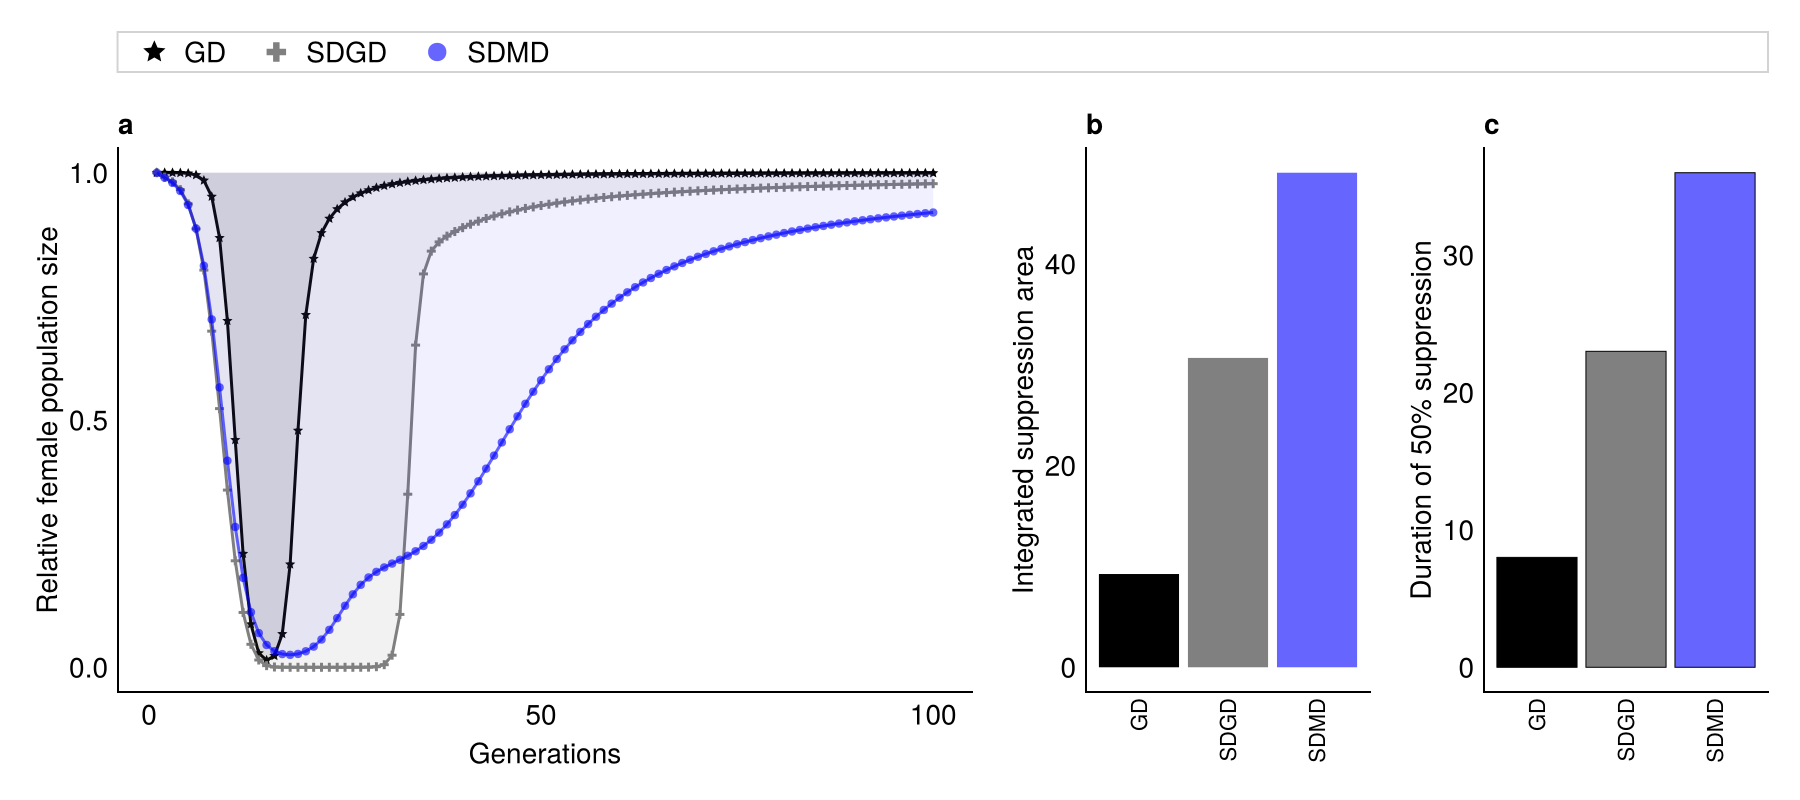

In [19]:
#IMPACT OF THE FITNESS ON THE POPULATION DYNAMICS (SEX DISTORTION=0.9, 0.99)
#b = 0.005, and HNEJ rates j= 0.035
f=Figure(size=(900,400))
#supertitle=Label(f[0,1:3], "Sex distortion and W/D female fitness effects on population suppression",fontsize=16,halign=:left)
ax1=Axis(f[1,1],title="a",titlealign=:left,ylabel="Relative female population size",xlabel="Generations")
gen=100

n=N0
mods=first.(IdealisedRuns) #population
modsI=last.(IdealisedRuns) #integrated area

for i in 1:3
    scatterlines!(ax1,1:gen,mean([mods[i][j][1:gen]./(0.5*n) for j in 1:rep]) ,color=cols3[i],marker=marks[i],markersize=6)
    band!(ax1,1:gen,mean([mods[i][j][1:gen]./(0.5*n) for j in 1:rep]),repeat([1],gen),alpha=0.1,color=(cols3[i],0.1),label=labelt[i])

end


ax2=Axis(f[1,2],title="b  ",ylabel="Integrated suppression area",xticks=(1:3,labelt),xticklabelrotation=pi/2,titlealign=:left,xticklabelsize=11)
is=[modsI[i][1][end] for i in 1:3]
barplot!(ax2,1:3,is,color=cols3,gap=0.1,strokecolor = :black, strokewidth = 0)#,direction=:x,color=col66)


ax3=Axis(f[1,3],title="c  ",ylabel="Duration of 50% suppression",xticks=(1:3,labelt),xticklabelrotation=pi/2,titlealign=:left,xticklabelsize=11)
ts=[TRest_095[i] for i in 1:3]
barplot!(ax3,1:3,ts,color=cols3,gap=0.1,strokecolor = :black, strokewidth = 0.5)

leg=[MarkerElement(color = cols3[i],markersize=13,marker=marks[i]) for i in 1:3];
Legend(f[0, 1:3], leg, ["GD","SDGD","SDMD"],"",titleposition=:left,orientation = :horizontal,padding=(0,0,0,0),halign=:left,colgap =15,tellwodth=false)#,framecolor=:lightgrey,framevisible=true)
Box(f[0, 1:3],color=(:white,0),strokewidth = 1,strokecolor=:lightgrey)

colsize!(f.layout, 1, Relative(3.6/6))
colsize!(f.layout, 2, Relative(1.2/6))
colsize!(f.layout, 3, Relative(1.2/6))
save("SDMDFigure1_idealised.png",f)
f

In [20]:
b=0.0016
EmpiricalRuns=
    [Runs_Nosp_dx(;N=N0,r1=0.5,rep=rep,C=c_GD,B=b,J=j_GD,F=12,hf=0,hN=0,hm=0,A=0,filename1="gdEmpB"),
     Runs_Nosp_dx(;N=N0,r1=r_SDGD,rep=rep,C=c_SDGD,B=b,J=j_SDGD,F=12,hf=0.38,hN=0,hm=0,A=0,filename1="sdgdEmpB"),
     Runs_Nosp_dx(;N=N0,r1=r_SDMD,rep=rep,C=c_SDMD,B=b,J=j_SDMD,F=12,hf=1,hDR=1,hN=0,hm=0,A=0,filename1="dxEmpB")
    ];

Progress: 100%|█████████████████████████████████████████| Time: 0:00:59
Progress: 100%|█████████████████████████████████████████| Time: 0:01:11
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


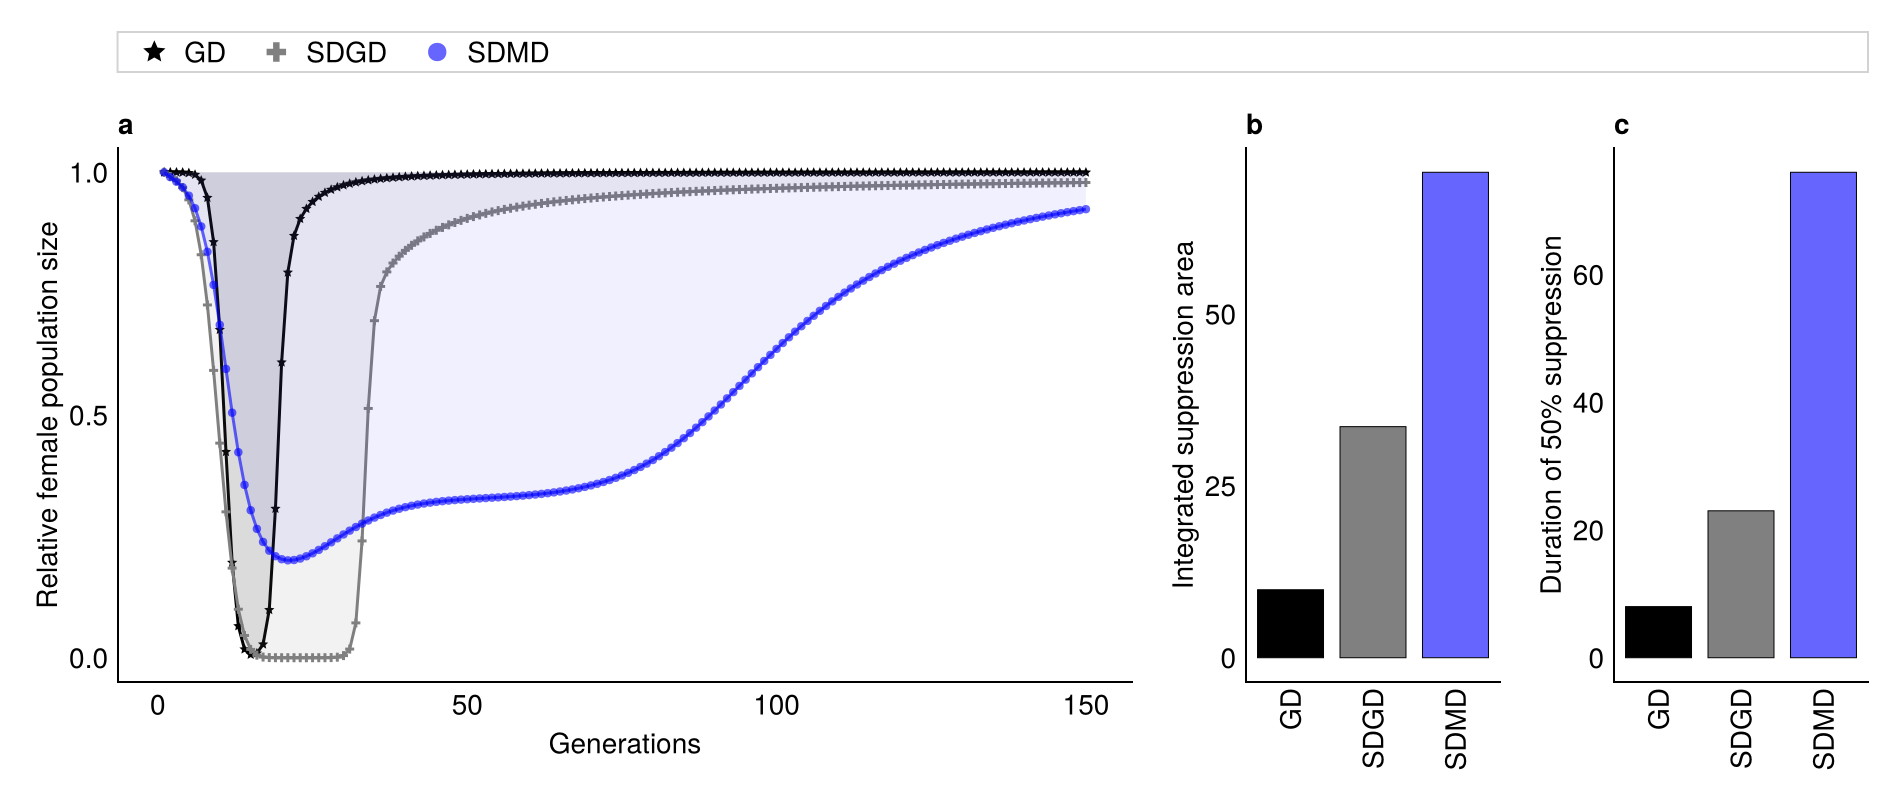

In [21]:
p=0.5
#DYNAMICS, INTEGRATED SUPPRESSION AREA AND DURATION OF PROTECTION FOR 3 EMPIRICAL CONSTRUCTS
f=Figure(size=(950,400))

n=N0
gen=150
mods=first.(EmpiricalRuns)
modsI=last.(EmpiricalRuns)

ax1=Axis(f[1,1],title="a ", ylabel="Relative female population size",xlabel="Generations",titlealign=:left)
for i in 1:3
    scatterlines!(ax1,1:gen,mean([mods[i][j][1:gen]./(0.5*n) for j in 1:rep]) ,color=cols3[i],marker=marks[i],markersize=6)
    band!(ax1,1:gen,mean([mods[i][j][1:gen]./(0.5*n) for j in 1:rep]),repeat([1],gen),alpha=0.1,color=(cols3[i],0.1),label=labelt[i])

end

ax2=Axis(f[1,2],title="b  ",ylabel="Integrated suppression area",xticks=(1:3,["GD","SDGD","SDMD"]),xticklabelrotation=pi/2,titlealign=:left)

y=[mean([modsI[i][j][end] for j in 1:rep]) for i in 1:3]

barplot!(ax2,1:3, y,color=cols3,strokecolor = :black, strokewidth = 0.5)
ax3=Axis(f[1,3],title="c  ",ylabel="Duration of 50% suppression",xticks=(1:3,["GD","SDGD","SDMD"]),titlealign=:left,xticklabelrotation=pi/2)
TRestEmp= [TimePerc(mods[i][1];perc=p)[2]-TimePerc(mods[i][1];perc=p)[1] for i in 1:3];
barplot!(ax3,1:3,TRestEmp[1:3],color=cols3,strokecolor = :black, strokewidth = 0.5)#,direction=:x)

colsize!(f.layout, 1, Relative(4/6))
colsize!(f.layout, 2, Relative(1/6))
colsize!(f.layout, 2, Relative(1/6))

leg=[MarkerElement(color = cols3[i],markersize=13,marker=marks[i]) for i in 1:3];
Legend(f[0, 1:3], leg, ["GD","SDGD","SDMD"],"",titleposition=:left,orientation = :horizontal,padding=(0,0,0,0),halign=:left,colgap =15,tellwodth=false)#,framecolor=:lightgrey,framevisible=true)
Box(f[0, 1:3],color=(:white,0),strokewidth = 1,strokecolor=:lightgrey)

save("SDMDFigure2_empirical.png",f)
f